# Project 01 - Color Compression


## Thông tin sinh viên


- Họ và tên: Nguyễn Lê Hồ Anh Khoa
- MSSV: 23127211
- Lớp: 23CLC09


## Import các thư viện liên quan


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import time


## Helper functions


In [ ]:
def read_img(img_path):
    """
    Read image from img_path

    Parameters
    ----------
    img_path : str
        Path of image

    Returns
    -------
        Image (2D)
    """

    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    return img_array


def show_img(img_2d):
    """
    Show image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    """

    plt.imshow(img_2d)
    plt.axis("off")
    plt.show()


def save_img(img_2d, img_path, export_type="png"):
    """
    Save image to img_path

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)
    img_path : str
        Path of image
    """

    full_path = f"{img_path}.{export_type}"
    img = Image.fromarray(np.uint8(img_2d))
    img.save(full_path)
    print(f"Image saved at: {full_path}")


def convert_img_to_1d(img_2d):
    """
    Convert 2D image to 1D image

    Parameters
    ----------
    img_2d : <your type>
        Image (2D)

    Returns
    -------
        Image (1D)
    """

    h, w, c = img_2d.shape
    return img_2d.reshape((h * w, c))


def kmeans(img_1d, k_clusters, max_iter, init_centroids="random"):
    """
    K-Means algorithm

    Parameters
    ----------
    img_1d : np.ndarray with shape=(height * width, num_channels)
        Original (1D) image
    k_clusters : int
        Number of clusters
    max_iter : int
        Max iterator
    init_centroids : str, default='random'
        The method used to initialize the centroids for K-means clustering
        'random' --> Centroids are initialized with random values between 0 and 255 for each channel
        'in_pixels' --> A random pixel from the original image is selected as a centroid for each cluster

    Returns
    -------
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Stores the color centroids for each cluster
    labels : np.ndarray with shape=(height * width, )
        Stores the cluster label for each pixel in the image
    """

    img_1d = img_1d.astype(np.float32)
    num_channels = img_1d.shape[1]

    if init_centroids == "random":
        centroids = set()
        while len(centroids) < k_clusters:
            new_centroid = tuple(np.random.randint(0, 256, size=num_channels))
            centroids.add(new_centroid)
        centroids = np.array(list(centroids), dtype=np.float32)
    else:
        centroids = set()
        while len(centroids) < k_clusters:
            new_centroid = img_1d[np.random.randint(0, len(img_1d))]
            centroids.add(tuple(new_centroid))
        centroids = np.array(list(centroids), dtype=np.float32)

    labels = np.zeros(len(img_1d), dtype=np.int32)

    count_iter = 0
    for _ in range(max_iter):
        old_centroids = centroids.copy()

        # Vectorized distance calculation
        diff = (
            img_1d[np.newaxis, :, :] - centroids[:, np.newaxis, :]
        )  # (k, n_pixels, 3)
        distances = np.sum(diff**2, axis=2)  # (k, n_pixels)
        labels = np.argmin(distances, axis=0)

        # Update centroids
        for i in range(k_clusters):
            points = img_1d[labels == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)

        if has_converged(old_centroids, centroids):
            count_iter = _ + 1
            break

    return centroids, labels, count_iter


def generate_2d_img(img_2d_shape, centroids, labels):
    """
    Generate a 2D image based on K-means cluster centroids

    Parameters
    ----------
    img_2d_shape : tuple (height, width, 3)
        Shape of image
    centroids : np.ndarray with shape=(k_clusters, num_channels)
        Store color centroids
    labels : np.ndarray with shape=(height * width, )
        Store label for pixels (cluster's index on which the pixel belongs)

    Returns
    -------
        New image (2D)
    """
    quantized_1d = centroids[labels]

    # Reshape back to 2D image
    quantized_2d = quantized_1d.reshape(img_2d_shape)

    return quantized_2d.astype(np.uint8)


def has_converged(old_centroids, new_centroids, tolerance=0.001):
    """
    Check for convergence based on the relative change of centroids.

    Parameters
    ----------
    old_centroids : np.ndarray
        Centroids from the previous iteration.
    new_centroids : np.ndarray
        Current centroids.
    tolerance : float, default=0.01
        The threshold for relative change (1% = 0.01).

    Returns
    -------
    bool : True if the centroids have converged.
    """
    diff = np.abs(old_centroids - new_centroids)
    relative_change = diff / (np.abs(old_centroids) + 1e-8)

    max_relative_change = np.max(relative_change)

    return max_relative_change < tolerance


## Your tests


In [ ]:
def benchmark(
    input_folder="input",
    output_folder="output",
    export_type="png",
    img_size=(1920, 1080),
):

    os.makedirs(output_folder, exist_ok=True)
    image_names = [f"test{i}.jpg" for i in range(1, 11)]

    def run_test(attr_name, values, fixed_params):
        avg_iters = []
        avg_times = []

        for val in values:
            times = []
            iters = []

            for img_name in image_names:
                img_path = os.path.join(input_folder, img_name)
                img_2d = read_img(img_path)
                img_2d_resized = np.array(Image.fromarray(img_2d).resize(img_size))
                img_1d = convert_img_to_1d(img_2d_resized)
                params = {
                    "k_clusters": fixed_params.get("k_clusters", 5),
                    "max_iter": fixed_params.get("max_iter", 20),
                    "init_centroids": fixed_params.get("init_centroids", "in_pixels"),
                }

                params[attr_name] = val
                start = time.time()
                centroids, labels, count_iter = kmeans(img_1d, **params)
                duration = time.time() - start
                times.append(duration)
                iters.append(count_iter)
                quantized_img = generate_2d_img(img_2d_resized.shape, centroids, labels)

                filename = f"{img_name[:-4]}_{attr_name}_{val}"
                out_path = os.path.join(output_folder, filename)
                save_img(quantized_img, out_path, export_type)

            avg_time = np.mean(times)
            avg_iter = np.mean(iters)

            avg_times.append(avg_time)
            avg_iters.append(avg_iter)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Plot runtime
        ax1.plot(values, avg_times, marker="o", color="blue")
        ax1.set_title(f"Runtime: {attr_name}")
        ax1.set_xlabel(attr_name)
        ax1.set_ylabel("Avg Runtime (s)")
        ax1.grid(True)

        # Plot iterations
        ax2.plot(values, avg_iters, marker="s", color="red")
        ax2.set_title(f"Iterations: {attr_name}")
        ax2.set_xlabel(attr_name)
        ax2.set_ylabel("Avg Iterations")
        ax2.grid(True)

        plt.tight_layout()
        chart_path = os.path.join(output_folder, f"chart_{attr_name}.{export_type}")
        plt.savefig(chart_path)
        plt.close()
        print(f"Saved chart: {chart_path}")

        # Print detailed results
        print(f"\nResults for {attr_name}:")
        print("-" * 40)
        for v, t, i in zip(values, avg_times, avg_iters):
            print(f"{attr_name}={v}: Runtime={t:.2f}s, Iterations={i:.1f}")

    # Test 1: max_iter
    run_test(
        "max_iter",
        [5, 20, 100, 200],
        fixed_params={"k_clusters": 5, "init_centroids": "in_pixels"},
    )

    # Test 2: init method
    run_test(
        "init_centroids",
        ["random", "in_pixels"],
        fixed_params={"k_clusters": 5, "max_iter": 100},
    )

    # Test 3: K clusters
    run_test(
        "k_clusters",
        [3, 5, 7, 9],
        fixed_params={"init_centroids": "in_pixels", "max_iter": 100},
    )


def display_and_save_results(input_folder, output_folder, save_dir="."):
    """Display and save test results with consistent image sizes"""

    def display_test_case(
        title, values, fixed_params, num_images=10, target_size=(810, 540)
    ):
        # First display performance charts
        chart_path = os.path.join(output_folder, f"chart_{title}.png")

        if os.path.exists(chart_path):
            plt.figure(figsize=(15, 5))
            plt.imshow(plt.imread(chart_path))
            plt.axis("off")
            plt.title(f"Performance Charts for {title}", pad=20)
            plt.savefig(
                os.path.join(save_dir, f"performance_{title}.png"), bbox_inches="tight"
            )
            plt.close()

        # For each parameter value
        for val in values:
            # Create figure for all images
            fig = plt.figure(figsize=(15, num_images * 2))
            fig.suptitle(
                f"{title} = {val}\nFixed parameters: {fixed_params}", fontsize=14
            )

            # Process all images at once
            for i in range(num_images):
                # Load and resize original image
                orig_path = os.path.join(input_folder, f"test{i+1}.jpg")
                if os.path.exists(orig_path):
                    orig_img = Image.open(orig_path).resize(target_size)
                    orig_colors = len(
                        np.unique(np.array(orig_img).reshape(-1, 3), axis=0)
                    )

                    # Original image
                    plt.subplot(num_images, 2, 2 * i + 1)
                    plt.imshow(orig_img)
                    plt.title(f"Original {i+1} ({orig_colors:,} colors)")
                    plt.axis("off")

                    # Processed image

                    plt.subplot(num_images, 2, 2 * i + 2)

                    processed_path = os.path.join(
                        output_folder, f"test{i+1}_{title}_{val}.png"
                    )

                    if os.path.exists(processed_path):
                        processed_img = Image.open(processed_path).resize(target_size)
                        plt.imshow(processed_img)
                        plt.axis("off")
            plt.tight_layout(rect=[0, 0.02, 1, 0.98])

            # Save the comparison figure
            save_path = os.path.join(save_dir, f"comparison_{title}_{val}.png")
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            plt.close()

    # Test configurations
    tests = [
        {
            "title": "max_iter",
            "values": [5, 20, 100, 200],
            "fixed_params": {"k_clusters": 5, "init_centroids": "in_pixels"},
        },
        {
            "title": "init_centroids",
            "values": ["random", "in_pixels"],
            "fixed_params": {"k_clusters": 5, "max_iter": 100},
        },
        {
            "title": "k_clusters",
            "values": [3, 5, 7, 9],
            "fixed_params": {"init_centroids": "in_pixels", "max_iter": 100},
        },
    ]

    # Process each test configuration

    for test in tests:
        display_test_case(test["title"], test["values"], test["fixed_params"])
        print(f"Saved comparisons for {test['title']}")


if __name__ == "__main__":
    input_folder = "input"
    output_folder = "output"
    export_type = "png"
    img_size = (1920, 1080)

    "If you want to use a different input folder, change the path here"
    "In input folder, you must have test1.jpg, test2.jpg, ..., test10.jpg"

    os.makedirs(input_folder, exist_ok=True)

    benchmark(input_folder, output_folder, export_type, img_size)

    display_and_save_results(input_folder, output_folder)


Saved comparisons for max_iter
Saved comparisons for init_centroids
Saved comparisons for k_clusters


## Main FUNCTION


In [ ]:
def main():
    img_input_path = input(
        "Enter the full path to the photo (e.g., input/example5.jpg): "
    ).strip()
    # img_input_path = "input/test2.jpg"
    img_2d = read_img(img_input_path)

    print("Original photo:")
    show_img(img_2d)

    img_1d = convert_img_to_1d(img_2d)
    print("Counting unique colors in the original image...")
    unique_colors = np.unique(img_1d, axis=0)
    print(f"Unique colors in the original image: {unique_colors.shape[0]} colors")

    k_clusters = int(input("Enter number of colors (clusters): "))
    # k_clusters = 5
    if k_clusters < 1 or k_clusters > unique_colors.shape[0]:
        print(
            f"Invalid number of clusters. Must be between 1 and {unique_colors.shape[0]}."
        )
        return
    max_iter = int(input("Enter max iterations for K-Means: "))
    init_method = input(
        "Choose centroid init method ('random' or 'in_pixels'): "
    ).strip()

    # max_iter = 300
    # init_method = "random"  # 'random' or 'in_pixels'

    start_time = time.time()
    centroids, labels, count_iter = kmeans(img_1d, k_clusters, max_iter, init_method)
    end_time = time.time()
    print(
        f"K-Means completed in {end_time - start_time:.2f} seconds with {k_clusters} clusters and break at iteration {count_iter}."
    )

    new_img_2d = generate_2d_img(img_2d.shape, centroids, labels)

    print(f"Photo after reducing color to {k_clusters} colors:")
    show_img(new_img_2d)

    base_name = os.path.basename(img_input_path).rsplit(".", 1)[0]
    output_path = os.path.join(f"{base_name}_compressed")

    valid_formats = {"jpg", "JPG", "jpeg", "JPEG", "png", "PNG", "pdf", "PDF"}
    # export_type = input("Enter file format to save (jpg, png, pdf): ").strip().lower()
    export_type = "JPG"

    if export_type not in valid_formats:
        print("Invalid file format. Allowed: jpg, png, pdf.")
        return

    save_img(new_img_2d, output_path, export_type)


Original photo:


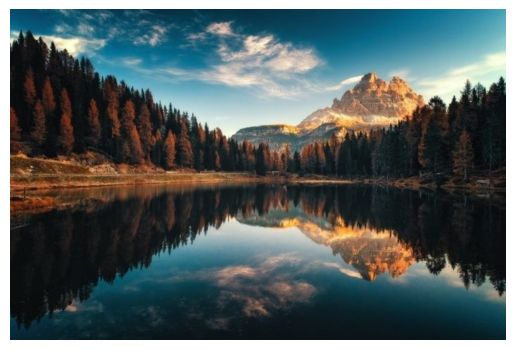

Counting unique colors in the original image...
Unique colors in the original image: 216069 colors
K-Means completed in 3.01 seconds with 5 clusters and break at iteration 19.
Photo after reducing color to 5 colors:


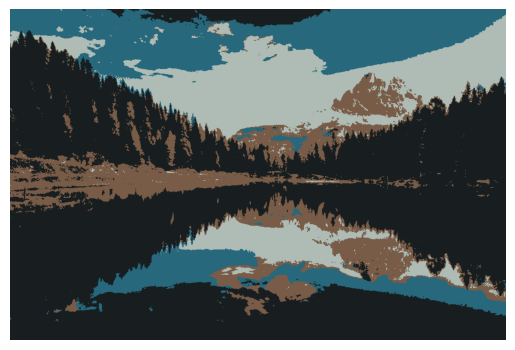

Image saved at: test2_compressed.JPG


In [ ]:
if __name__ == "__main__":
    main()


# Nhận xét

- Chất lượng ảnh, có gần giống ảnh gốc không
- Độ đo
- Tốc độ chạy
